## Abstract

This project evaluates whether sexually selected traits can be used to classify animal taxa with machine learning, comparing binary presence/absence data against evolutionary origin rates. To reduce sparsity, phyla were grouped into five superphyla and modeled with decision trees, random forests, and logistic regression, using balanced accuracy and macro F1 to account for uneven classes. Exploratory analysis showed the binary dataset was sparse and dominated by Arthropoda, limiting predictive power, while the evolutionary dataset was more balanced but skewed and correlated. Results indicated that binary data performed poorly across all models, whereas evolutionary rates provided stronger signal, with logistic regression achieving the highest accuracy and macro F1. SHAP analysis confirmed that binary models relied almost entirely on the “sexually selected” flag, while evolutionary models distributed importance across visual, competition, auditory, and female choice traits. Overall, evolutionary rates offered more predictive value than binary presence. Problems seen in modelings would suggest the need for improved data quality and modeling approaches.

## Introduction

**Introduction**

Classifying animals was pretty challenging due to boundaries blur across body plans, life histories, and genomes, and even well-sampled groups can be tricky. I wanted to see how far standard machine-learning methods can go when asked a simple question: can sexually selected traits predict higher-level groups, and which traits matter most? This project tests that idea and compares two kinds of signal—presence/absence style traits versus rate-style traits—to see which carries more predictive power.

**Methodology**

To cut sparsity and keep results readable, I group many phyla into five superphyla for modeling only: 
- Ecdysozoa
- Lophotrochozoa
- Deuterostomia
- Basal Metazoa & Non-Bilaterians
- Basal Bilateria. 

I will use the following: Logistic Regression, Decision Trees, and Random Forest, and use SHAP to check what these classifiers actually use to make decisions. But, to clarify, the focus is not to replace phylogenetics or other classification methods for animal-related scientist roles, but to gauge what models add, where models break, and how the setup could be improved.

**Potential**

If the approach proves useful, it could guide follow-up work, streamline handling of ambiguous cases when classifying, and point to better trait design or data collection for future studies.

---

## Full Data Analysis

### Imported Libraries

Here are all the imported libraries needed to do the full data analysis below:


In [4]:
import numpy as np              # numbers, arrays, math
import pandas as pd             # tables, csv loading, data handling
import os    
import matplotlib.pyplot as plt   # plotting
import shap                       # shap values for model explainability
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier       # decision tree model
from sklearn.ensemble import RandomForestClassifier   # random forest model
from sklearn.linear_model import LogisticRegression   # logistic regression model

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score   # cross validation scoring
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

#note: micromamba activate data_science_foundation to pip install and resolve shap issues

Libraries version below:

In [ ]:
import sys, json
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import shap
import sklearn

versions = {
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": sns.__version__,
    "scikit-learn": sklearn.__version__,
    "shap": shap.__version__,
    "os": "stdlib",   # standard library; no version
}

print(json.dumps(versions, indent=2))

{
  "python": "3.12.9",
  "numpy": "2.2.4",
  "pandas": "2.2.2",
  "matplotlib": "3.10.1",
  "seaborn": "0.13.2",
  "scikit-learn": "1.7.1",
  "shap": "0.48.0",
  "os": "stdlib"
}


---

### EDA Assessments

#### Loading Data

In [6]:
#making a function to load the data (from HW 03-04)

#prompt the input for file path then load the data
def load_data():
    try:
        folder_name = input("Enter the folder path: ") #copy the path of the folder (right clicked data folder and copy path)
        file_list = [f for f in os.listdir(folder_name) if f.endswith('.csv')] #searches files with csv extension in that folder
        print(f"Files found in {folder_name}: {file_list}") #lists all matching files
        
        for file in file_list: #tries to load each file into each variable separately
            var_name = os.path.splitext(file)[0]  #'customers' from 'customers.csv' for example
            globals()[var_name] = pd.read_csv(os.path.join(folder_name, file)) #set each file name as a variable
            print(f"Loaded {file} as variable '{var_name}'")
            
    except FileNotFoundError: #error handling
        print(f"Folder '{folder_name}' not found.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    return True 

#calling the function (copy data folder entire path into the prompt box)
load_data()

Files found in /Users/matthewthompson/Documents/Academics/DS Masters Academics/Data Mining and Discovery/Assignments/final-project-thompson/data: ['family_related_data.csv', 'animals_rateof_evolution.csv']
Loaded family_related_data.csv as variable 'family_related_data'
Loaded animals_rateof_evolution.csv as variable 'animals_rateof_evolution'


True

Two named df:
- family_related_data
- animals_rateof_evolution

In [7]:
family_df = family_related_data  
evolution_df = animals_rateof_evolution

Renamed to family_df and evolution_df for simplicity

In [8]:
print(family_df.info())

print(evolution_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tree_Label  1087 non-null   object
 1   Phylum      1087 non-null   object
 2   SS          1087 non-null   int64 
 3   A           1087 non-null   int64 
 4   G           1087 non-null   int64 
 5   O           1087 non-null   int64 
 6   T           1087 non-null   int64 
 7   V           1087 non-null   int64 
 8   C           1087 non-null   int64 
 9   F           1087 non-null   int64 
 10  K           1087 non-null   int64 
 11  M           1087 non-null   int64 
 12  S           1087 non-null   int64 
dtypes: int64(11), object(2)
memory usage: 110.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tree    84 non-null     int64  
 1   Phylum  84 non-n

**Family dataset)**

This dataset has 1,087 rows and 13 columns, containing tree labels, phylum information, and 11 integer-coded traits which are essentially binary.

**Evolution dataset)**

This dataset is much smaller with 84 rows and 12 columns, including phylum and traits stored as floats for continuous values (for the evolutionary rates).

**IMPORTANT NOTE**

According to the metadata: these floats in the evolution dataset are actually model-derived (obtained by maximum likelihood analysis)

#### Family EDA Assessments

In [9]:
###### SHAPE AND INFO

#family dataset below
df1 = family_df.copy()
dataset_name = "family_df"

# quick overview
print(f"\n=== {dataset_name} EDA ===")
print(f"Shape: {df1.shape[0]} rows × {df1.shape[1]} columns")
print("\nColumns:", list(df1.columns))
print("\nDtypes:\n", df1.dtypes)

# pick likely target + trait columns
all_traits = ['SS','A','G','O','T','V','C','F','K','M','S']
traits_present = [c for c in all_traits if c in df1.columns]
target_col = 'Phylum' if 'Phylum' in df1.columns else None
id_cols = [c for c in ['Tree_Label'] if c in df1.columns]

#prints out the shape below
print("\nTarget column:", target_col)
print("Trait columns:", traits_present)
print("ID columns:", id_cols)



=== family_df EDA ===
Shape: 1087 rows × 13 columns

Columns: ['Tree_Label', 'Phylum', 'SS', 'A', 'G', 'O', 'T', 'V', 'C', 'F', 'K', 'M', 'S']

Dtypes:
 Tree_Label    object
Phylum        object
SS             int64
A              int64
G              int64
O              int64
T              int64
V              int64
C              int64
F              int64
K              int64
M              int64
S              int64
dtype: object

Target column: Phylum
Trait columns: ['SS', 'A', 'G', 'O', 'T', 'V', 'C', 'F', 'K', 'M', 'S']
ID columns: ['Tree_Label']


The family_df dataset has 1,087 rows and 13 columns, where Phylum is the categorical target, 11 numeric trait columns (SS–S) are features (binary), and Tree_Label acts as an identifier. This makes it well-structured for classification tasks predicting phylum from trait patterns.

In [10]:
##### SUMMARY INFO numerics and categoricals

# numeric & categorical summaries:
numeric_df = df1.select_dtypes(include='number')
cat_df = df1.select_dtypes(include=['object','category'])

#prints summaries below
if not numeric_df.empty:
    print("\nSummary (numeric):\n", numeric_df.describe().T)
else:
    print("\nNo numeric columns for numeric summary.")

if not cat_df.empty:
    print("\nSummary (categorical):\n", cat_df.describe().T)
else:
    print("\nNo categorical columns for categorical summary.")



Summary (numeric):
      count      mean       std  min  25%  50%  75%  max
SS  1087.0  0.269549  0.443930  0.0  0.0  0.0  1.0  1.0
A   1087.0  0.037718  0.190602  0.0  0.0  0.0  0.0  1.0
G   1087.0  0.021159  0.143981  0.0  0.0  0.0  0.0  1.0
O   1087.0  0.103036  0.304146  0.0  0.0  0.0  0.0  1.0
T   1087.0  0.131555  0.338162  0.0  0.0  0.0  0.0  1.0
V   1087.0  0.093836  0.291735  0.0  0.0  0.0  0.0  1.0
C   1087.0  0.109476  0.312379  0.0  0.0  0.0  0.0  1.0
F   1087.0  0.181233  0.385388  0.0  0.0  0.0  0.0  1.0
K   1087.0  0.007360  0.085512  0.0  0.0  0.0  0.0  1.0
M   1087.0  0.107636  0.310062  0.0  0.0  0.0  0.0  1.0
S   1087.0  0.015639  0.124133  0.0  0.0  0.0  0.0  1.0

Summary (categorical):
            count unique          top freq
Tree_Label  1087   1087    1Laevipil    1
Phylum      1087     29  Arthropoda   917


The numeric traits are mostly binary (0/1) with low mean values, showing that most traits are absent in most samples, except SS (27%) and F (18%), which occur more frequently (sum of 1s divided by total value). Categorical data shows each Tree_Label is unique, and the dataset is highly imbalanced, with Arthropoda dominating (917 of 1087, ~84%) among the 29 phyla for 'Phylum'.

In [11]:
# missing values
na = df1.isna().sum()
na = na[na > 0]

#if any NA, prints error otherwise missing values
if na.empty:
    print("\nNo missing values detected.")
else:
    print("\nColumns with nulls:\n", na)
    print("\nNull %:\n", (na/len(df)*100).round(2))


No missing values detected.


In [12]:
# unique counts
print("\nUnique values per column:\n", df1.nunique())


Unique values per column:
 Tree_Label    1087
Phylum          29
SS               2
A                2
G                2
O                2
T                2
V                2
C                2
F                2
K                2
M                2
S                2
dtype: int64


In [13]:
#outlier scan (IQR) – skip pure binary columns
print("\nOutlier scan (IQR):")
for col in numeric_df.columns:
    vals = df1[col].dropna().unique()
    #treat as binary if values subset of {0,1}
    if set(vals).issubset({0,1,0.0,1.0}):
        print(f"{col}: skipped (binary)")
        continue
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lo = Q1 - 1.5*IQR
    hi = Q3 + 1.5*IQR
    mask = (df1[col] < lo) | (df1[col] > hi) #mark values below Q1−1.5*IQR or above Q3+1.5*IQR as outliers
    cnt = int(mask.sum()) #count how many outliers there are below or outside IQR
    pct = 100*cnt/len(df1) #percentage of outliers
    print(f"{col}: {cnt} outliers ({pct:.2f}%)") #reports outlier count and %



Outlier scan (IQR):
SS: skipped (binary)
A: skipped (binary)
G: skipped (binary)
O: skipped (binary)
T: skipped (binary)
V: skipped (binary)
C: skipped (binary)
F: skipped (binary)
K: skipped (binary)
M: skipped (binary)
S: skipped (binary)


Since all trait columns are binary (0/1), an IQR-based outlier scan is not applicable — there are no true numeric outliers in this dataset. The traits can only vary by presence/absence, not by extreme values

In [14]:
# Skewness
if not numeric_df.empty:
    with np.errstate(all='ignore'):
        skew_vals = numeric_df.drop(columns=id_cols, errors='ignore').skew(numeric_only=True)

        print("\n=== Skewness ===")
        for col, val in skew_vals.items():
            print(f"{col:5s}: {val: .4f}")
else:
    print("\nNo numeric columns for skewness in Family dataset.")

# Kurtosis
if not numeric_df.empty:
    with np.errstate(all='ignore'):
        kurt_vals = numeric_df.drop(columns=id_cols, errors='ignore').kurt(numeric_only=True)

        print("\n=== Kurtosis ===")
        for col, val in kurt_vals.items():
            print(f"{col:5s}: {val: .4f}")
else:
    print("\nNo numeric columns for kurtosis in Family dataset.")



=== Skewness ===
SS   :  1.0401
A    :  4.8597
G    :  6.6637
O    :  2.6152
T    :  2.1831
V    :  2.7896
C    :  2.5049
F    :  1.6573
K    :  11.5434
M    :  2.5355
S    :  7.8183

=== Kurtosis ===
SS   : -0.9198
A    :  21.6564
G    :  42.4832
O    :  4.8480
T    :  2.7711
V    :  5.7925
C    :  4.2826
F    :  0.7481
K    :  131.4920
M    :  4.4371
S    :  59.2347


All traits are positively skewed, meaning trait presence (1) is rare compared to absence (0). The strongest skew and highest kurtosis occur in K (female-female competition), S (intersexual conflict), and G (gustatory), showing these traits are extremely sparse, while more common traits like SS (any sexually selected trait) and F (female choice) are less skewed.


Correlation matrix (|r|):
           SS         A         G         O         T         V         C  \
SS  1.000000  0.315031  0.242030  0.551115  0.634572  0.529735  0.577181   
A   0.315031  1.000000  0.138659  0.107623  0.051520  0.135007  0.100703   
G   0.242030  0.138659  1.000000  0.097360  0.056249  0.128062  0.010604   
O   0.551115  0.107623  0.097360  1.000000  0.100862  0.119243  0.123462   
T   0.634572  0.051520  0.056249  0.100862  1.000000  0.294774  0.639344   
V   0.529735  0.135007  0.128062  0.119243  0.294774  1.000000  0.453005   
C   0.577181  0.100703  0.010604  0.123462  0.639344  0.453005  1.000000   
F   0.763723  0.370670  0.295909  0.539708  0.375067  0.438281  0.202182   
K   0.141746  0.039448  0.012660  0.041626  0.157547  0.119935  0.211111   
M   0.571720  0.274021  0.134572  0.722016  0.137071  0.163090  0.039847   
S   0.207496  0.052882  0.136029  0.054837  0.258047  0.061146  0.027045   

           F         K         M         S  
SS  0.763723  

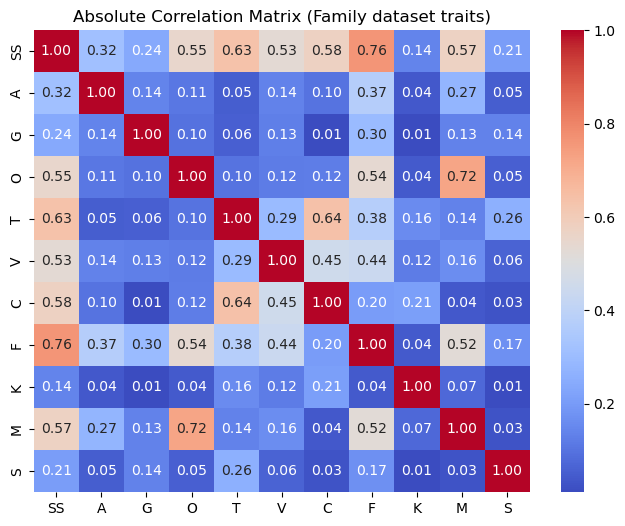

In [15]:
# correlations (absolute) among numeric
if not numeric_df.empty:
    corr = numeric_df.corr().abs()
    print("\nCorrelation matrix (|r|):\n", corr)

if corr is not None:
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Absolute Correlation Matrix (Family dataset traits)")
    plt.show()

The strongest associations are SS–F (0.76), O–M (0.72), T–C (0.64), and SS–T (0.63), showing that combined sexually selected traits strongly co-occur with female choice, and olfactory traits with male choice. Visual (V), tactile (T), and male–male competition (C) also form a moderately correlated cluster, while weaker links (e.g., K and S) indicate that female–female competition and intersexual conflict occur largely independently of other traits

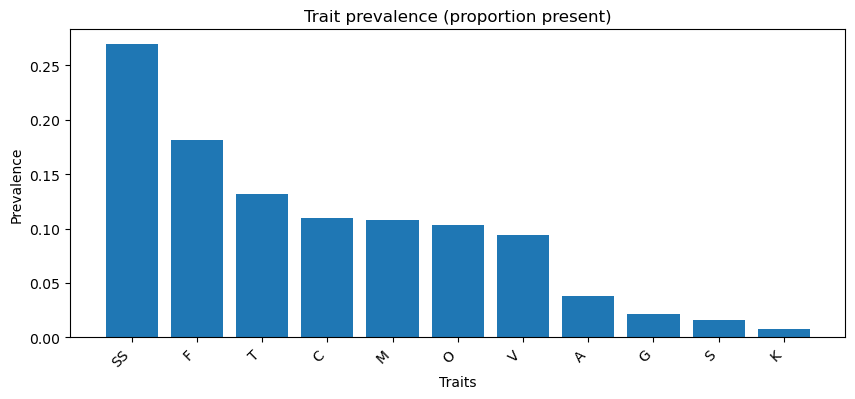

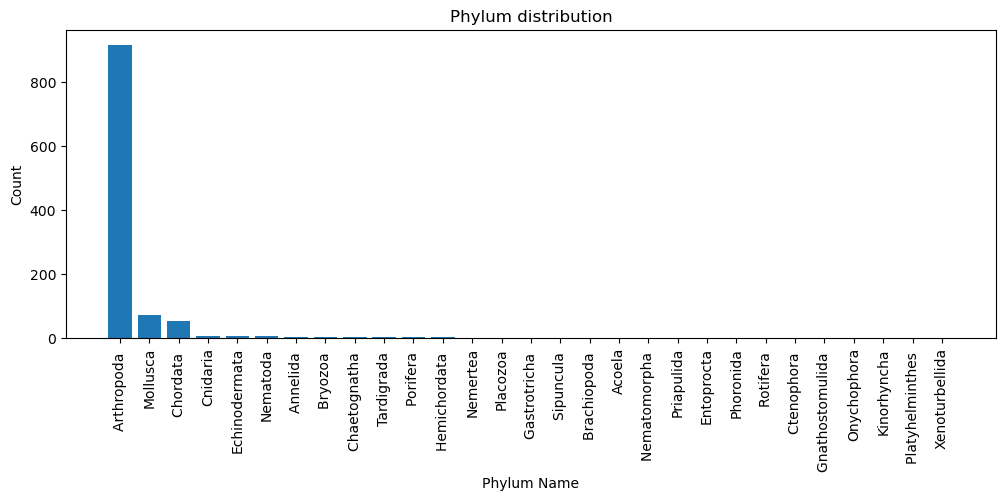

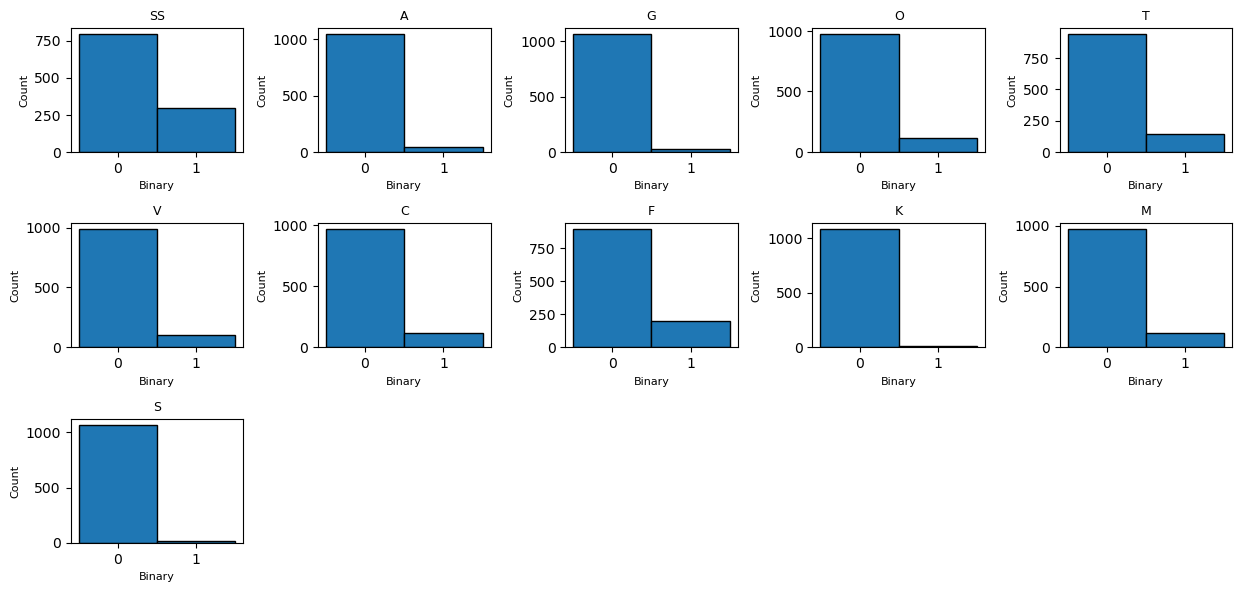

In [16]:
# plots – trait prevalence, phylum distribution, histograms (binary will show as 0/1 counts)

#prevalence of binary traits
if traits_present:
    prev = df1[traits_present].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(prev.index, prev.values)
    plt.title("Trait prevalence (proportion present)")
    plt.ylabel("Prevalence")
    plt.xlabel("Traits")
    plt.xticks(rotation=45, ha='right')
    plt.show()

#phylum distribution
if target_col:
    counts = df1[target_col].value_counts()
    plt.figure(figsize=(12,4))
    plt.bar(counts.index, counts.values)
    plt.title(f"{target_col} distribution")
    plt.ylabel("Count")
    plt.xlabel("Phylum Name")
    plt.xticks(rotation=90)
    plt.show()

binary_cols = [c for c in traits_present if c in df1.columns]

# histograms for binary traits (0/1 only)
if binary_cols:
    n = len(binary_cols)
    ncols = min(5, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(2.5*ncols, 2*nrows)  # shrink each plot
    )
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(binary_cols):
        ax = axes[i]
        ax.hist(df1[col].dropna(), bins=[-0.5, 0.5, 1.5], edgecolor="black")
        ax.set_title(col, fontsize=9)  # smaller title font
        ax.set_xticks([0, 1])
        ax.set_xlabel("Binary", fontsize=8)
        ax.set_ylabel("Count", fontsize=8)

    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout(pad=1.0)  # tighter spacing
    plt.show()


Trait prevalence by phylum (proportion present):
                      SS      A      G      O      T      V      C     F  \
Phylum                                                                    
Acoela            0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Annelida          0.500  0.000  0.000  0.500  0.500  0.000  0.250  0.25   
Arthropoda        0.296  0.037  0.025  0.115  0.149  0.098  0.115  0.20   
Brachiopoda       0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Bryozoa           0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Chaetognatha      0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Chordata          0.346  0.135  0.000  0.077  0.077  0.212  0.231  0.25   
Cnidaria          0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Ctenophora        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Echinodermata     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.00   
Entoprocta        0.000  0.000  0.000  0.000  0.0

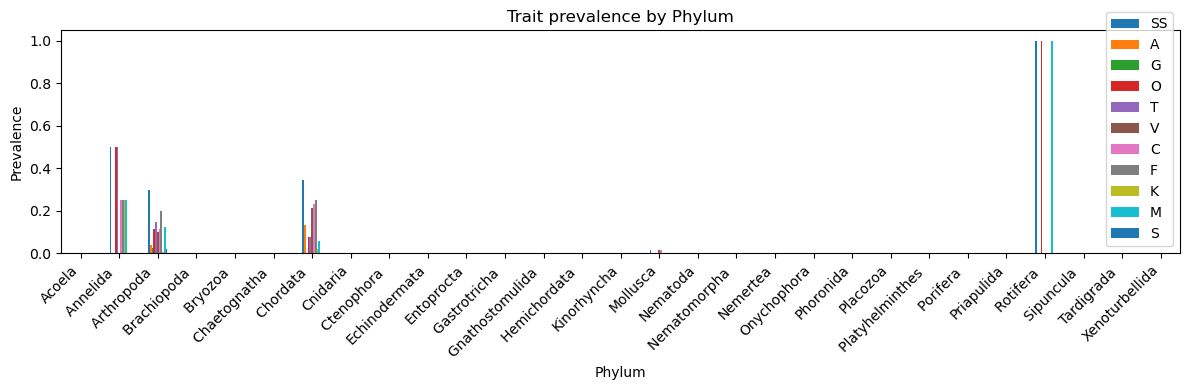

In [17]:
# traits by phylum (prevalence), if target exists
if target_col and traits_present:
    group_prev = df1.groupby(target_col)[traits_present].mean().sort_index()
    print("\nTrait prevalence by phylum (proportion present):\n", group_prev.round(3))

    #barplot per trait aggregated (wide)
    ax = group_prev.plot(kind='bar', figsize=(12, max(4, 0.35*len(group_prev.columns))))
    ax.set_title(f"Trait prevalence by {target_col}")
    ax.set_ylabel("Prevalence")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [18]:
#trait prevalence by phylum
group_prev = df1.groupby("Phylum")[['SS','A','G','O','T','V','C','F','K','M','S']].mean()

#filter to only show phylum × traits where prevalence > 0
filtered_prev = group_prev[group_prev > 0].dropna(how="all")

print("Non-zero trait prevalence by phylum (df1):\n")
print(filtered_prev)

Non-zero trait prevalence by phylum (df1):

                   SS         A         G         O         T         V  \
Phylum                                                                    
Annelida     0.500000       NaN       NaN  0.500000  0.500000       NaN   
Arthropoda   0.295529  0.037077  0.025082  0.114504  0.149400  0.098146   
Chordata     0.346154  0.134615       NaN  0.076923  0.076923  0.211538   
Mollusca     0.014286       NaN       NaN       NaN       NaN  0.014286   
Rotifera     1.000000       NaN       NaN  1.000000       NaN       NaN   

                    C         F         K         M         S  
Phylum                                                         
Annelida     0.250000  0.250000  0.250000  0.250000       NaN  
Arthropoda   0.114504  0.199564  0.006543  0.122137  0.018539  
Chordata     0.230769  0.250000  0.019231  0.057692       NaN  
Mollusca     0.014286       NaN       NaN       NaN       NaN  
Rotifera          NaN       NaN       NaN  1.0

Trait prevalence (first plot):
- The most common trait is SS (any sexually selected trait, ~27%), followed by F (female choice, ~18%) and T (tactile, ~13%), while traits like K (female–female competition), S (intersexual conflict), and G (gustatory) are rare (<3%).

Phylum distribution (second plot):
- The dataset is highly imbalanced, with Arthropoda dominating (~84%), while Mollusca and Chordata make up smaller fractions, and most other phyla have very few samples.

Trait binary presence (third plot):
- All traits are binary with strong skew toward 0 (absence), confirming sparsity and explaining the high skewness/kurtosis values.

Trait prevalence by phylum (fourth plot):
- Certain phyla (e.g., Arthropoda, Chordata, Annelida) show meaningful diversity of trait presence, while most phyla exhibit almost no sexually selected traits in the dataset.

#### Evolution EDA Assessments

In [19]:
#making a copy of evolution_df
df2 = evolution_df.copy()

# quick overview
print(f"\n=== df2 EDA (evolution_df) ===")
print(f"Shape: {df2.shape[0]} rows × {df2.shape[1]} columns")
print("\nColumns:", list(df2.columns))
print("\nDtypes:\n", df2.dtypes)

# target and trait columns
all_traits = ['A','G','O','T','V','C','F','K','M','S']  # continuous traits
traits_present = [c for c in all_traits if c in df2.columns]
target_col = 'Phylum' if 'Phylum' in df2.columns else None
id_cols = [c for c in ['Tree'] if c in df2.columns]

#printed shapes below
print("\nTarget column:", target_col)
print("Trait columns:", traits_present)
print("ID columns:", id_cols)



=== df2 EDA (evolution_df) ===
Shape: 84 rows × 12 columns

Columns: ['Tree', 'Phylum', 'A', 'G', 'O', 'T', 'V', 'C', 'F', 'K', 'M', 'S']

Dtypes:
 Tree        int64
Phylum     object
A         float64
G         float64
O         float64
T         float64
V         float64
C         float64
F         float64
K         float64
M         float64
S         float64
dtype: object

Target column: Phylum
Trait columns: ['A', 'G', 'O', 'T', 'V', 'C', 'F', 'K', 'M', 'S']
ID columns: ['Tree']


The evolution_df dataset (84 rows × 12 columns) tracks evolutionary origin rates of 10 sexually selected traits (A–S) across phyla, providing continuous rate-based predictors rather than the binary presence/absence data of family_df.

In [20]:
# numeric & categorical summaries
numeric_df = df2.select_dtypes(include='number')
cat_df = df2.select_dtypes(include=['object','category'])

if not numeric_df.empty:
    print("\nSummary (numeric):\n", numeric_df.describe().T)
else:
    print("\nNo numeric columns for numeric summary.")

if not cat_df.empty:
    print("\nSummary (categorical):\n", cat_df.describe().T)
else:
    print("\nNo categorical columns for categorical summary.")



Summary (numeric):
       count      mean       std  min  25%  50%  75%       max
Tree   84.0  2.000000  0.821401  1.0  1.0  2.0  3.0  3.000000
A      84.0  0.000019  0.000069  0.0  0.0  0.0  0.0  0.000301
G      84.0  0.000063  0.000528  0.0  0.0  0.0  0.0  0.004833
O      84.0  0.000028  0.000100  0.0  0.0  0.0  0.0  0.000400
T      84.0  0.000056  0.000230  0.0  0.0  0.0  0.0  0.001200
V      84.0  0.000117  0.000456  0.0  0.0  0.0  0.0  0.002300
C      84.0  0.000066  0.000234  0.0  0.0  0.0  0.0  0.001000
F      84.0  0.000089  0.000323  0.0  0.0  0.0  0.0  0.001341
K      84.0  0.000005  0.000018  0.0  0.0  0.0  0.0  0.000088
M      84.0  0.000028  0.000106  0.0  0.0  0.0  0.0  0.000509
S      84.0  0.000004  0.000020  0.0  0.0  0.0  0.0  0.000108

Summary (categorical):
        count unique         top freq
Phylum    84     28  Tardigrada    3


The evolution_df traits have extremely small mean rates (mostly near 0 with rare spikes), showing that sexually selected traits originate very infrequently across lineages; meanwhile, the categorical data span 28 phyla with a relatively even spread (max frequency only 3 for Tardigrada), making this dataset far more balanced than family_df (confirmed in the phylum distribution plot below)

In [21]:
# missing values
na = df2.isna().sum()
na = na[na > 0]
if na.empty:
    print("\nNo missing values detected.")
else:
    print("\nColumns with nulls:\n", na)
    print("\nNull %:\n", (na/len(df2)*100).round(2))



No missing values detected.


In [22]:
# unique counts
print("\nUnique values per column:\n", df2.nunique())



Unique values per column:
 Tree       3
Phylum    28
A          6
G          3
O          5
T          6
V          5
C          6
F          6
K          5
M          6
S          4
dtype: int64


Each trait in evolution_df only has a few unique rate values (mostly 3–6), so even though they’re stored as continuous numbers, the values are very small and clustered. The dataset still covers 28 phyla, giving it wide taxonomic coverage but not much variation within each trait.

In [23]:
#outlier scan (IQR) – continuous traits only
print("\nOutlier scan (IQR):")
for col in numeric_df.columns:
    if col in id_cols:  # skip ID
        print(f"{col}: skipped (ID)")
        continue
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    lo = Q1 - 1.5*IQR
    hi = Q3 + 1.5*IQR
    mask = (df2[col] < lo) | (df2[col] > hi) #mark values below or above IQR method for detecting outliers above
    cnt = int(mask.sum()) #counts these values
    pct = 100*cnt/len(df2) #percentage of outliers
    print(f"{col}: {cnt} outliers ({pct:.2f}%)") 


Outlier scan (IQR):
Tree: skipped (ID)
A: 6 outliers (7.14%)
G: 3 outliers (3.57%)
O: 6 outliers (7.14%)
T: 6 outliers (7.14%)
V: 9 outliers (10.71%)
C: 9 outliers (10.71%)
F: 6 outliers (7.14%)
K: 6 outliers (7.14%)
M: 6 outliers (7.14%)
S: 3 outliers (3.57%)


follows up with the outlier details below:

In [24]:
#traits to scan (exclude ID/target)
trait_cols = [c for c in df2.columns if c not in ["Tree", "Phylum"]]

#IQR outlier finder (returns both high and low outliers)
def find_outliers_iqr(d, col):
    q1 = d[col].quantile(0.25)
    q3 = d[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    out = d[(d[col] < lower) | (d[col] > upper)].copy()
    out["OutlierSide"] = out[col].apply(lambda x: "low" if x < lower else "high")
    out["Trait"] = col
    return out[["Trait", "Phylum", col, "OutlierSide"]].rename(columns={col: "Value"})

#dict of DataFrames per trait
outlier_dict = {col: find_outliers_iqr(df2, col) for col in trait_cols}

#tidy table of all outliers (stacked)
outliers_tidy = pd.concat(outlier_dict.values(), ignore_index=True)

#counts by trait
outlier_counts_by_trait = (
    outliers_tidy.groupby("Trait", as_index=False)
    .size()
    .rename(columns={"size": "n_outliers"})
    .sort_values("n_outliers", ascending=False)
)

#phyla contributing outliers per trait
phyla_per_trait = (
    outliers_tidy.groupby("Trait")["Phylum"]
    .apply(lambda s: ", ".join(sorted(s.unique())))
    .reset_index(name="Phyla_with_outliers")
)

#combined into one summary
outlier_summary = outlier_counts_by_trait.merge(phyla_per_trait, on="Trait", how="left")

print("Outlier summary (IQR):")
print(outlier_summary.to_string(index=False))

Outlier summary (IQR):
Trait  n_outliers            Phyla_with_outliers
    C           9 Arthropoda, Chordata, Mollusca
    V           9 Arthropoda, Chordata, Mollusca
    A           6           Arthropoda, Chordata
    F           6           Arthropoda, Chordata
    K           6           Arthropoda, Chordata
    M           6           Arthropoda, Chordata
    O           6           Arthropoda, Chordata
    T           6           Arthropoda, Chordata
    G           3                     Arthropoda
    S           3                     Arthropoda


Outliers in trait evolution rates are almost entirely concentrated in Arthropoda and Chordata, with Mollusca contributing only for Visual and Male–male competition, while all other phyla show none. It suggests sexually selected traits are usually found in Arthropoda, Chordata, and a bit of Mollusca. Unfortunately, evolution rates are pretty imbalanced here as well.

In [25]:
# Skewness
if not numeric_df.empty:
    with np.errstate(all='ignore'):
        skew_vals = numeric_df.drop(columns=id_cols, errors='ignore').skew(numeric_only=True)

        print("\n=== Skewness ===")
        for col, val in skew_vals.items():
            print(f"{col:5s}: {val: .4f}")
else:
    print("\nNo numeric columns for skewness.")

# Kurtosis
if not numeric_df.empty:
    with np.errstate(all='ignore'):
        kurt_vals = numeric_df.drop(columns=id_cols, errors='ignore').kurt(numeric_only=True)

        print("\n=== Kurtosis ===")
        for col, val in kurt_vals.items():
            print(f"{col:5s}: {val: .4f}")
else:
    print("\nNo numeric columns for kurtosis.")


=== Skewness ===
A    :  3.5053
G    :  9.0968
O    :  3.3938
T    :  4.4907
V    :  4.2405
C    :  3.4515
F    :  3.4248
K    :  4.0070
M    :  3.8618
S    :  5.0951

=== Kurtosis ===
A    :  10.8319
G    :  83.1277
O    :  9.7628
T    :  19.7685
V    :  17.6104
C    :  10.3801
F    :  10.0587
K    :  15.5086
M    :  14.1807
S    :  24.5445


All trait origin rates are strongly right-skewed with high kurtosis, meaning most values sit near zero while a few phyla show much higher rates. The most extreme cases are Gustatory (G) and Intersexual conflict (S), which are both very rare and unevenly distributed. The least skewed are Olfactory (O, ~3.39) and Female choice (F, ~3.42), but even these remain heavily tilted to the right rather than balanced.


Correlation matrix (|r|):
        A      G      O      T      V      C      F      K      M      S
A  1.000  0.365  0.990  0.805  0.962  0.967  0.998  0.980  0.906  0.585
G  0.365  1.000  0.450  0.603  0.209  0.484  0.383  0.257  0.542  0.628
O  0.990  0.450  1.000  0.879  0.915  0.992  0.996  0.942  0.955  0.691
T  0.805  0.603  0.879  1.000  0.613  0.928  0.842  0.670  0.980  0.952
V  0.962  0.209  0.915  0.613  1.000  0.862  0.942  0.997  0.756  0.342
C  0.967  0.484  0.992  0.928  0.862  1.000  0.981  0.896  0.982  0.770
F  0.998  0.383  0.996  0.842  0.942  0.981  1.000  0.964  0.932  0.638
K  0.980  0.257  0.942  0.670  0.997  0.896  0.964  1.000  0.802  0.410
M  0.906  0.542  0.955  0.980  0.756  0.982  0.932  0.802  1.000  0.874
S  0.585  0.628  0.691  0.952  0.342  0.770  0.638  0.410  0.874  1.000


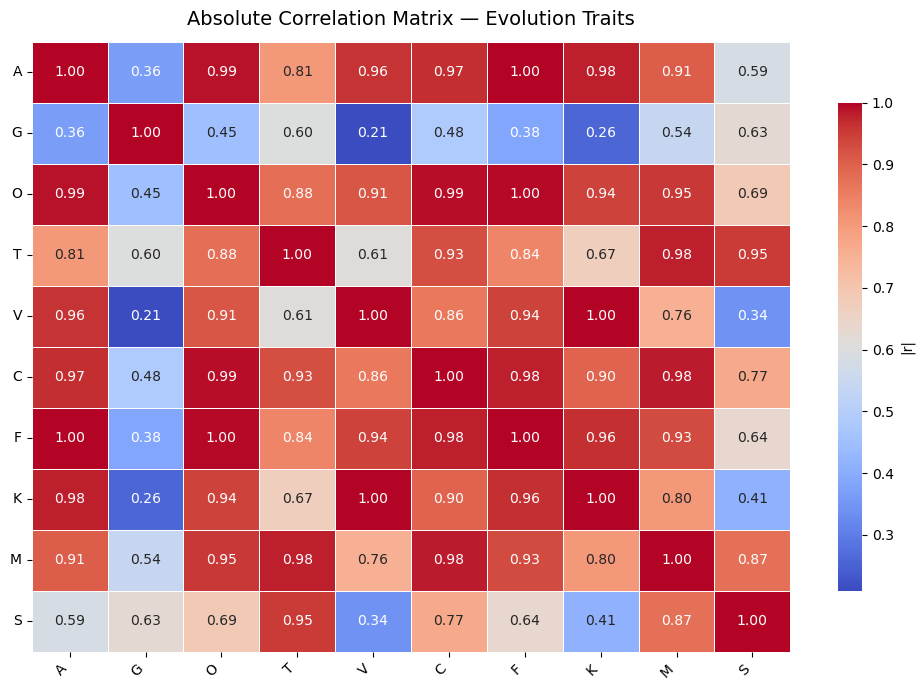

In [26]:
#correlations
cont_cols = [c for c in traits_present if c in df2.columns]
if cont_cols:
    corr = df2[cont_cols].corr().abs()
    print("\nCorrelation matrix (|r|):\n", corr.round(3))

    # Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        corr,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "|r|"}
    )
    plt.title("Absolute Correlation Matrix — Evolution Traits", fontsize=14, pad=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No continuous trait columns found in df2.")

This here, is interesting. Most sexually selected traits in evolution_df are almost perfectly correlated, possibly forming a tight co-evolving cluster (auditory, olfactory, visual, competition, and choice traits). The only exception is gustatory (G), which shows weaker links and stands out as the most independent trait. 

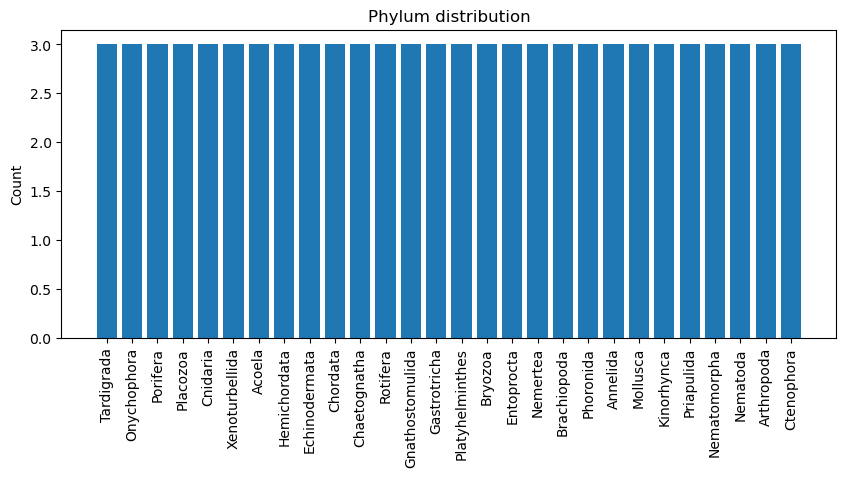

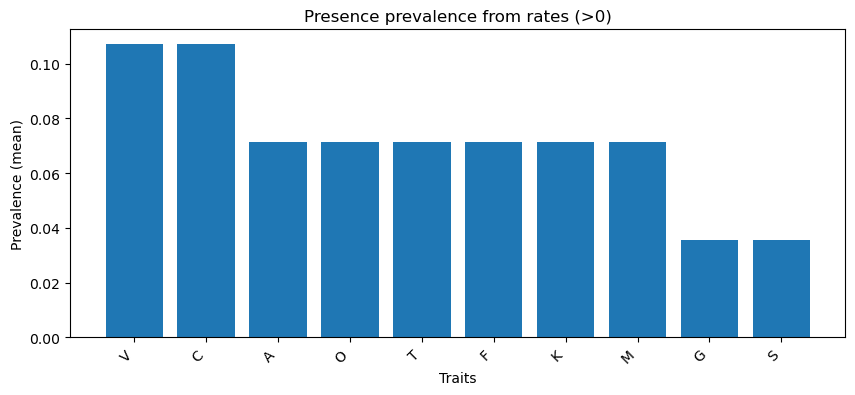

In [27]:
# plots – histograms, phylum distribution, presence prevalence

#phylum distribution
if target_col:
    counts = df2[target_col].value_counts()
    plt.figure(figsize=(10,4))
    plt.bar(counts.index, counts.values)
    plt.title(f"{target_col} distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()

#presence prevalence derived from rates (>0)
if cont_cols:
    presence = (df2[cont_cols] > 0).mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(presence.index, presence.values)
    plt.title("Presence prevalence from rates (>0)")
    plt.ylabel("Prevalence (mean)")
    plt.xlabel("Traits")
    plt.xticks(rotation=45, ha='right')
    plt.show()



Trait means by phylum:
                    A      G    O      T      V      C      F    K      M    S
Phylum                                                                       
Acoela           0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Annelida         0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Arthropoda       0.0  0.002  0.0  0.001  0.001  0.001  0.001  0.0  0.001  0.0
Brachiopoda      0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Bryozoa          0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Chaetognatha     0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Chordata         0.0  0.000  0.0  0.000  0.002  0.001  0.001  0.0  0.000  0.0
Cnidaria         0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Ctenophora       0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Echinodermata    0.0  0.000  0.0  0.000  0.000  0.000  0.000  0.0  0.000  0.0
Entoprocta       0.0  0.000  0.0  0.000

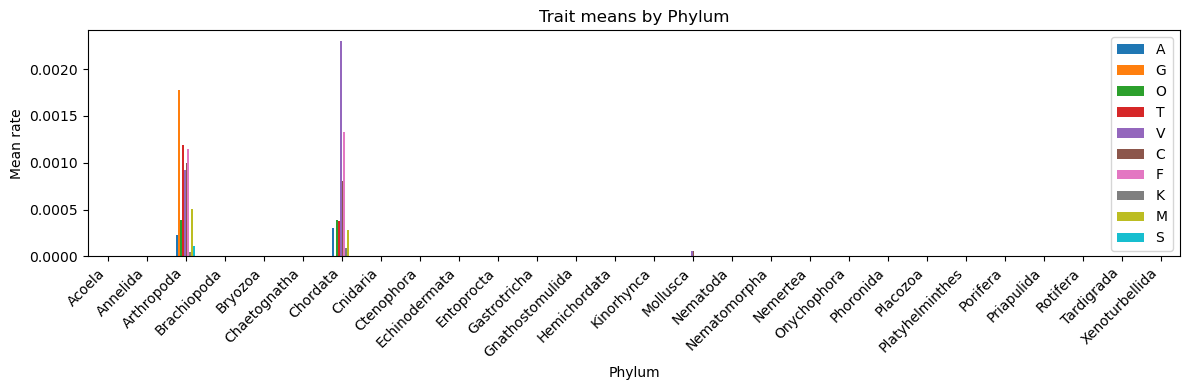

In [28]:
#trait means by phylum
if target_col and cont_cols:
    means_by_phylum = df2.groupby(target_col)[cont_cols].mean().sort_index()
    print("\nTrait means by phylum:\n", means_by_phylum.round(3))

    ax = means_by_phylum.plot(kind='bar', figsize=(12, max(4, 0.35*len(means_by_phylum.columns))))
    ax.set_title(f"Trait means by {target_col}")
    ax.set_ylabel("Mean rate")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [29]:
#filter df2 trait means by phylum to only show > 0 values
trait_means = df2.groupby("Phylum")[['A','G','O','T','V','C','F','K','M','S']].mean()
filtered = trait_means[trait_means > 0].dropna(how="all")

print("Non-zero trait means by phylum:\n")
print(filtered)

Non-zero trait means by phylum:

                   A         G         O         T         V         C  \
Phylum                                                                   
Arthropoda  0.000227  0.001774  0.000384  0.001187  0.000923  0.000997   
Chordata    0.000299       NaN  0.000387  0.000377  0.002300  0.000800   
Mollusca         NaN       NaN       NaN       NaN  0.000059  0.000059   

                   F         K         M         S  
Phylum                                              
Arthropoda  0.001152  0.000043  0.000506  0.000108  
Chordata    0.001333  0.000087  0.000276       NaN  
Mollusca         NaN       NaN       NaN       NaN  


Phylum distribution (first plot):
- All phyla are evenly represented (3 each) which means the class representation is balanced.

Trait prevalence (second plot):
- The most common evolving traits are Visual (V) and Male–male competition (C), whereas Gustatory (G) and Intersexual conflict (S) are the rarest

Traits by phylum (third plot):
- This third plot confirms the imbalanced evolutionary rates across phyla where a lot of detected sexually selected traits are usually found in Arthropoda, Chordata, and a bit of Mollusca. 

#### Summarized Key Insights 

**Family**
- Dataset structure: The dataset has 1,087 rows × 13 columns, with Phylum as the categorical target, 11 binary-coded sexually selected traits (SS–S) as predictors, and Tree_Label as a unique ID.
- Severe class imbalance: The Arthropoda phylum dominates (~84%), while Mollusca (~8%) and Chordata (~5%) are minor classes, and most other phyla have only a handful of samples. This imbalance will strongly affect classification performance.
- Trait prevalence patterns: Most traits are rare, with SS (any sexually selected trait, ~27%) and F (female choice, ~18%) being the most frequent. In contrast, K (female–female competition), S (intersexual conflict), and G (gustatory) appear in <3% of samples, meaning they contribute very sparse signals.
- Distribution shape: Because traits are binary and sparse, they show strong positive skew and extreme kurtosis, indicating most samples lack a given trait. This makes the dataset sparse and unbalanced at both feature and target levels.
- Correlation structure: Traits cluster into co-occurring groups:
- SS and F are very tightly linked (r ≈ 0.76),
- Olfactory (O) and Male choice (M) also correlate strongly (r ≈ 0.72),
- Tactile (T) and Male–male competition (C) pair closely (r ≈ 0.64).
  - These clusters suggest certain evolutionary mechanisms tend to evolve together.
- By phylum trait diversity: Only a few phyla (Arthropoda, Chordata, Annelida) show meaningful variation in sexually selected traits. However, most other phyla have near-zero prevalence, meaning trait-driven classification will be heavily biased toward the larger groups.

**Evolution**
- Dataset structure: 84 rows × 12 columns; 10 continuous trait rate columns (A–S), Phylum as target, Tree as ID.
- Class balance: 28 phyla, each appearing exactly 3 times → perfectly balanced distribution.
- Trait distributions: All traits are heavily right-skewed with high kurtosis, clustered near zero with only a few high values.
- Outliers: Concentrated almost entirely in Arthropoda and Chordata, with Mollusca contributing for Visual (V) and Male–male competition (C).
- Trait prevalence (nonzero rates): Most common are Visual (V) and Male–male competition (C) (~11%), while Gustatory (G) and Intersexual conflict (S) are the rarest (~4%). [“Presence prevalence from rates (>0 → 1)” bar chart]
- Correlations: Nearly all traits co-evolve in a tight cluster (correlations >0.95), with Gustatory (G) standing out as the least connected trait.

Family_df shows which traits are present or absent but is heavily skewed toward Arthropoda, while Evolution_df tracks how likely traits evolve across phyla, with a balanced sample, although traits are not balanced and strongly co-correlated together.

---

### Data Preprocessing (Preparations for ML)

#### Family Preprocessing

I made a copy of family_df known as family_preprocessing

In [30]:
# Make a copy for preprocessing steps
family_preprocessing = family_df.copy()

# Drop ID column (Tree_Label)
if "Tree_Label" in family_preprocessing.columns:
    family_preprocessing = family_preprocessing.drop(columns=["Tree_Label"])

family_preprocessing.head()

,Phylum,SS,A,G,O,T,V,C,F,K,M,S
0,Mollusca,0,0,0,0,0,0,0,0,0,0,0
1,Mollusca,0,0,0,0,0,0,0,0,0,0,0
2,Chordata,0,0,0,0,0,0,0,0,0,0,0
3,Chordata,0,0,0,0,0,0,0,0,0,0,0
4,Chordata,0,0,0,0,0,0,0,0,0,0,0


I won't be using tree_label in the modeling

In [31]:
#strip leading/trailing spaces in Phylum column
family_preprocessing["Phylum"] = family_preprocessing["Phylum"].astype(str).str.strip()

#defined superphylum groupings (after some research)
groups = {
    "Ecdysozoa": {
        "Arthropoda", "Nematoda", "Nematomorpha", "Priapulida",
        "Kinorhyncha", "Kinorhynca", "Tardigrada", "Onychophora"
    },
    "Lophotrochozoa": {
        "Mollusca", "Annelida", "Brachiopoda", "Bryozoa",
        "Phoronida", "Nemertea", "Rotifera", "Gastrotricha",
        "Gnathostomulida", "Sipuncula", "Platyhelminthes", "Entoprocta"
    },
    "Deuterostomia": {
        "Chordata", "Echinodermata", "Hemichordata"
    },
    "Basal Metazoa & Non-Bilaterians": {
        "Porifera", "Placozoa", "Cnidaria", "Ctenophora"
    },
    "Basal Bilateria": {
        "Acoela", "Chaetognatha", "Xenoturbellida"
    }
}

#mapping dictionary
phylum_to_group = {}
for group_name, phyla in groups.items():
    for p in phyla:
        phylum_to_group[p] = group_name

#addedSuperphylum column
family_preprocessing["Superphylum"] = family_preprocessing["Phylum"].map(phylum_to_group)

# Coverage check
unique_phyla = set(family_preprocessing["Phylum"].unique())
assigned = [p for p in unique_phyla if p in phylum_to_group]
unassigned = [p for p in unique_phyla if p not in phylum_to_group]

df_map = pd.DataFrame({
    "Phylum": sorted(unique_phyla),
    "Assigned_Group": [phylum_to_group.get(p, "") for p in sorted(unique_phyla)],
    "Is_Assigned": [p in phylum_to_group for p in sorted(unique_phyla)]
})

#header
print(family_preprocessing.head())

     Phylum  SS  A  G  O  T  V  C  F  K  M  S     Superphylum
0  Mollusca   0  0  0  0  0  0  0  0  0  0  0  Lophotrochozoa
1  Mollusca   0  0  0  0  0  0  0  0  0  0  0  Lophotrochozoa
2  Chordata   0  0  0  0  0  0  0  0  0  0  0   Deuterostomia
3  Chordata   0  0  0  0  0  0  0  0  0  0  0   Deuterostomia
4  Chordata   0  0  0  0  0  0  0  0  0  0  0   Deuterostomia


Now I can encode superphylum and will not be including phylum to avoid redundancy

In [32]:
# encode Superphylum target
sup_le = LabelEncoder()
family_preprocessing["Superphylum_encoded"] = sup_le.fit_transform(
    family_preprocessing["Superphylum"].astype(str)
)

# features = trait flags only (exclude Superphylum columns)
trait_cols = ["SS","A","G","O","T","V","C","F","K","M","S"]
X = family_preprocessing[trait_cols].copy()
y = family_preprocessing["Superphylum_encoded"].copy()

print("Classes:", dict(enumerate(sup_le.classes_)))

Classes: {0: 'Basal Bilateria', 1: 'Basal Metazoa & Non-Bilaterians', 2: 'Deuterostomia', 3: 'Ecdysozoa', 4: 'Lophotrochozoa'}


As you may note, family have extremely unbalanced class representations, so I added class weights to aid with balanced classes for model predictions

In [33]:
#train/test split
X_train_fam, X_test_fam, y_train_fam, y_test_fam = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#class weights
classes = np.unique(y_train_fam)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_fam)
cw_fam = {c: w for c, w in zip(classes, class_weights)}

#standardize features below
scaler_fam = StandardScaler()
X_train_fam_scaled = scaler_fam.fit_transform(X_train_fam)
X_test_fam_scaled  = scaler_fam.transform(X_test_fam)

print("Train/Test:", X_train_fam.shape, X_test_fam.shape)
print("Class weights:", cw_fam)

#after preprocessing, making a copy of the preprocessed data -> family_ML for model evaluations
family_ML = family_preprocessing.copy()

Train/Test: (869, 11) (218, 11)
Class weights: {np.int64(0): np.float64(57.93333333333333), np.int64(1): np.float64(19.31111111111111), np.int64(2): np.float64(3.697872340425532), np.int64(3): np.float64(0.23423180592991913), np.int64(4): np.float64(2.5558823529411763)}


#### Evolution Preprocessing

I made a copy of evolution_df named evolution_preprocessing here

In [34]:
#making a copy for preprocessing steps
evolution_preprocessing = evolution_df.copy()

#Drop ID column (Tree_label)
if "Tree" in evolution_preprocessing.columns:
    evolution_preprocessing = evolution_preprocessing.drop(columns=["Tree"])

evolution_preprocessing.head()

,Phylum,A,G,O,T,V,C,F,K,M,S
0,Tardigrada,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Onychophora,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arthropoda,0.000228,0.000244,0.000376,0.00118,0.000935,0.000995,0.001178,0.000043,0.000509,0.000108
3,Nematoda,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Nematomorpha,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [35]:
#stripped whitespace from Phylum names
evolution_preprocessing["Phylum"] = evolution_preprocessing["Phylum"].astype(str).str.strip()

#defined superphylum groupings
groups = {
    "Ecdysozoa": {
        "Arthropoda", "Nematoda", "Nematomorpha", "Priapulida",
        "Kinorhyncha", "Kinorhynca", "Tardigrada", "Onychophora"
    },
    "Lophotrochozoa": {
        "Mollusca", "Annelida", "Brachiopoda", "Bryozoa",
        "Phoronida", "Nemertea", "Rotifera", "Gastrotricha",
        "Gnathostomulida", "Sipuncula", "Platyhelminthes", "Entoprocta"
    },
    "Deuterostomia": {
        "Chordata", "Echinodermata", "Hemichordata"
    },
    "Basal Metazoa & Non-Bilaterians": {
        "Porifera", "Placozoa", "Cnidaria", "Ctenophora"
    },
    "Basal Bilateria": {
        "Acoela", "Chaetognatha", "Xenoturbellida"
    }
}

#mapping dictionary
phylum_to_group = {}
for group_name, phyla in groups.items():
    for p in phyla:
        phylum_to_group[p] = group_name

#added Superphylum column
evolution_preprocessing["Superphylum"] = evolution_preprocessing["Phylum"].map(phylum_to_group)

#verify coverage below
unique_phyla = set(evolution_preprocessing["Phylum"].unique())
unassigned = [p for p in unique_phyla if p not in phylum_to_group]

print("Total unique phyla:", len(unique_phyla))
print("Unassigned phyla (should be empty):", unassigned)
evolution_preprocessing.head()


Total unique phyla: 28
Unassigned phyla (should be empty): []


,Phylum,A,G,O,T,V,C,F,K,M,S,Superphylum
0,Tardigrada,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Ecdysozoa
1,Onychophora,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Ecdysozoa
2,Arthropoda,0.000228,0.000244,0.000376,0.00118,0.000935,0.000995,0.001178,0.000043,0.000509,0.000108,Ecdysozoa
3,Nematoda,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Ecdysozoa
4,Nematomorpha,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Ecdysozoa


It shows that I was able to group literally all phyla correctly into superphyla groups leaving nothing unassigned, so it should work for family as well

In [36]:
#encoding superphylum:
#encode Superphylum into numeric labels, keep the text column
encoder = LabelEncoder()
evolution_preprocessing["Superphylum_encoded"] = encoder.fit_transform(
    evolution_preprocessing["Superphylum"].astype(str)
)

#mapping for reference
superphylum_classes = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Superphylum encoding mapping:", superphylum_classes)

evolution_preprocessing[["Phylum", "Superphylum", "Superphylum_encoded"]].head()

Superphylum encoding mapping: {'Basal Bilateria': np.int64(0), 'Basal Metazoa & Non-Bilaterians': np.int64(1), 'Deuterostomia': np.int64(2), 'Ecdysozoa': np.int64(3), 'Lophotrochozoa': np.int64(4)}


,Phylum,Superphylum,Superphylum_encoded
0,Tardigrada,Ecdysozoa,3
1,Onychophora,Ecdysozoa,3
2,Arthropoda,Ecdysozoa,3
3,Nematoda,Ecdysozoa,3
4,Nematomorpha,Ecdysozoa,3


I encoded superphylum and intended to use it as a target variable for both family and evolution DF

In [37]:
# encoding and log + scaling 

#encode Superphylum (target)
superphylum_le_evo = LabelEncoder()
evolution_preprocessing["Superphylum_encoded"] = superphylum_le_evo.fit_transform(
    evolution_preprocessing["Superphylum"].astype(str)
)

#defined features: 
#continuous rates only (drop phylum target completely)
rate_cols = ["A","G","O","T","V","C","F","K","M","S"]
X_rates = evolution_preprocessing[rate_cols]
y_evo = evolution_preprocessing["Superphylum_encoded"]

#Log transform the rates
X_log = np.log1p(X_rates)

#standardized features below
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

#final features are just scaled rates
X_evo_final = X_scaled

#one per class in test (stratify on superphyla now)
X_train_evo, X_test_evo, y_train_evo, y_test_evo = train_test_split(
    X_evo_final, y_evo,
    test_size=1/3,     
    random_state=42,
    stratify=y_evo
)

#mapping for decoding predictions later
superphylum_id_to_name_evo = {i: n for i, n in enumerate(superphylum_le_evo.classes_)}

print("Train/Test shapes:", X_train_evo.shape, X_test_evo.shape)
print("Unique superphyla:", len(superphylum_id_to_name_evo))
print("Example mapping (id -> name):", list(superphylum_id_to_name_evo.items())[:5])

#evolution_preprocessing copy into evolution_ML
evolution_ML = evolution_preprocessing.copy()

#header
print(evolution_ML.head())

Train/Test shapes: (56, 10) (28, 10)
Unique superphyla: 5
Example mapping (id -> name): [(0, 'Basal Bilateria'), (1, 'Basal Metazoa & Non-Bilaterians'), (2, 'Deuterostomia'), (3, 'Ecdysozoa'), (4, 'Lophotrochozoa')]
         Phylum         A         G         O        T         V         C  \
0    Tardigrada  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
1   Onychophora  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
2    Arthropoda  0.000228  0.000244  0.000376  0.00118  0.000935  0.000995   
3      Nematoda  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
4  Nematomorpha  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   

          F         K         M         S Superphylum  Superphylum_encoded  
0  0.000000  0.000000  0.000000  0.000000   Ecdysozoa                    3  
1  0.000000  0.000000  0.000000  0.000000   Ecdysozoa                    3  
2  0.001178  0.000043  0.000509  0.000108   Ecdysozoa                    3  
3  0.00

The reason I train split 1/3 instead of 1/2 is due to smaller sample size for evolution with around 84 samples

Now, I have both family and evolution preprocessed and made copies in case (family_ML and evolution_ML)

---

### Modeling Evaluations

#### Family Modeling

In [ ]:
# =========================================================
#Family below

RANDOM_STATE = 42  # keep consistent

# Features & Target 
trait_cols_fam = ["SS","A","G","O","T","V","C","F","K","M","S"]  # exclude Superphylum_encoded
X_fam_all = family_ML[trait_cols_fam].copy()
y_fam_all = family_ML["Superphylum_encoded"].copy()              # target is Superphylum

# Stratified Split
X_train_fam, X_test_fam, y_train_fam, y_test_fam = train_test_split(
    X_fam_all, y_fam_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_fam_all
)

# Class Weights (from TRAIN)
classes_fam = np.unique(y_train_fam)
weights_fam = compute_class_weight("balanced", classes=classes_fam, y=y_train_fam)
cw_fam = {c: w for c, w in zip(classes_fam, weights_fam)}

# Scale for LR only
scaler_fam = StandardScaler()
X_train_fam_scaled = scaler_fam.fit_transform(X_train_fam)
X_test_fam_scaled  = scaler_fam.transform(X_test_fam)

# Models
dt_fam = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight=cw_fam,
    max_depth=8,
    min_samples_split=4,
    min_samples_leaf=2
)

rf_fam = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=1   #disabled parallelism (repeated warnings)
)

lr_fam = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_STATE,
    class_weight=cw_fam,
    multi_class="multinomial",
    C=0.5,
    solver="lbfgs",
    n_jobs=1
)

# Train
dt_fam.fit(X_train_fam, y_train_fam)
rf_fam.fit(X_train_fam, y_train_fam)
lr_fam.fit(X_train_fam_scaled, y_train_fam)

# Predictions
dt_pred_fam = dt_fam.predict(X_test_fam)
rf_pred_fam = rf_fam.predict(X_test_fam)
lr_pred_fam = lr_fam.predict(X_test_fam_scaled)

# Evaluation
print("=== FAMILY (Superphylum) RESULTS ===")
labels_eval = np.unique(y_test_fam)

for name, pred in [
    ("Decision Tree", dt_pred_fam),
    ("Random Forest", rf_pred_fam),
    ("Logistic Regression", lr_pred_fam),
]:
    acc  = accuracy_score(y_test_fam, pred)
    balc = balanced_accuracy_score(y_test_fam, pred)
    f1m  = f1_score(y_test_fam, pred, average="macro", labels=labels_eval, zero_division=0)
    print(f"\n{name}: acc={acc:.3f} | bal_acc={balc:.3f} | macro-F1={f1m:.3f}")
    print(classification_report(y_test_fam, pred, labels=labels_eval, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test_fam, pred, labels=labels_eval))

# CV on random forest
min_count_fam = pd.Series(y_fam_all).value_counts().min()
if min_count_fam >= 3:
    n_splits_fam = int(min(5, min_count_fam))
    cv_folds_fam = StratifiedKFold(n_splits=n_splits_fam, shuffle=True, random_state=RANDOM_STATE)
    fam_cv_rf = cross_val_score(
        rf_fam, X_fam_all, y_fam_all, cv=cv_folds_fam, scoring="f1_macro", n_jobs=1  # <-- disable parallelism
    )
    print(f"\n[FAMILY Superphylum] RF {n_splits_fam}-fold CV macro-F1: {fam_cv_rf.mean():.3f} ± {fam_cv_rf.std():.3f}")
else:
    print("\n[FAMILY Superphylum] Skipping CV: smallest class < 3 samples.")


/Users/matthewthompson/micromamba/envs/data_science_foundation/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== FAMILY (Superphylum) RESULTS ===

Decision Tree: acc=0.147 | bal_acc=0.280 | macro-F1=0.087
              precision    recall  f1-score   support

           0       0.01      1.00      0.01         1
           1       0.00      0.00      0.00         2
           2       0.12      0.25      0.16        12
           3       0.93      0.15      0.26       186
           4       0.00      0.00      0.00        17

    accuracy                           0.15       218
   macro avg       0.21      0.28      0.09       218
weighted avg       0.80      0.15      0.23       218

Confusion matrix:
 [[  1   0   0   0   0]
 [  2   0   0   0   0]
 [  8   0   3   1   0]
 [136   0  22  28   0]
 [ 16   0   0   1   0]]

Random Forest: acc=0.229 | bal_acc=0.283 | macro-F1=0.128
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.01      1.00      0.02         2
           2       0.33      0.17      0.22        12
    

In [39]:
# =========================================================
# Summary of FAMILY (Superphylum) Results

print("=== FAMILY (Superphylum) SUMMARY ===")

print("\nDecision Tree")
print(" - Accuracy: 0.147")
print(" - Balanced Accuracy: 0.280")
print(" - Macro F1: 0.087")
print(" - Strong bias toward majority class, poor minority performance.")

print("\nRandom Forest")
print(" - Accuracy: 0.229")
print(" - Balanced Accuracy: 0.283")
print(" - Macro F1: 0.128")
print(" - Slightly better than Decision Tree, but still dominated by majority class.")

print("\nLogistic Regression")
print(" - Accuracy: 0.216")
print(" - Balanced Accuracy: 0.296")
print(" - Macro F1: 0.129")
print(" - Similar to Random Forest, recalls minority class a little better.")

print("\nCross-Validation (Random Forest)")
print(" - 4-fold CV Macro F1: 0.109 ± 0.011")
print(" - Confirms weak generalization across classes.")


=== FAMILY (Superphylum) SUMMARY ===

Decision Tree
 - Accuracy: 0.147
 - Balanced Accuracy: 0.280
 - Macro F1: 0.087
 - Strong bias toward majority class, poor minority performance.

Random Forest
 - Accuracy: 0.229
 - Balanced Accuracy: 0.283
 - Macro F1: 0.128
 - Slightly better than Decision Tree, but still dominated by majority class.

Logistic Regression
 - Accuracy: 0.216
 - Balanced Accuracy: 0.296
 - Macro F1: 0.129
 - Similar to Random Forest, recalls minority class a little better.

Cross-Validation (Random Forest)
 - 4-fold CV Macro F1: 0.109 ± 0.011
 - Confirms weak generalization across classes.


#### Evolution Modeling

In [40]:
# =========================================================
#Evolution below

rate_cols = ["A","G","O","T","V","C","F","K","M","S"]

# build modeling matrix from evolution_ML
X_rates_all = evolution_ML[rate_cols].copy()
X_super_all = evolution_ML[["Superphylum_encoded"]].copy()
y_evo_all = evolution_ML["Superphylum_encoded"].copy()   # <— target is Superphylum now

# log1p rates
X_log_all = np.log1p(X_rates_all)

# z-score rates
scaler_evo = StandardScaler()
X_scaled_all = scaler_evo.fit_transform(X_log_all)

# stack with unscaled Superphylum code
X_evo_all = X_scaled_all

# stratified split 2:1 (1/3 test)
X_train_evo, X_test_evo, y_train_evo, y_test_evo = train_test_split(
    X_evo_all, y_evo_all, test_size=1/3, random_state=RANDOM_STATE, stratify=y_evo_all
)

# models
dt_evo = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")
rf_evo = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced_subsample")
lr_evo = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight="balanced", multi_class="ovr")

# train & predict
dt_evo.fit(X_train_evo, y_train_evo)
rf_evo.fit(X_train_evo, y_train_evo)
lr_evo.fit(X_train_evo, y_train_evo)  # already scaled representation

dt_pred_evo = dt_evo.predict(X_test_evo)
rf_pred_evo = rf_evo.predict(X_test_evo)
lr_pred_evo = lr_evo.predict(X_test_evo)

print("\n=== EVOLUTION RESULTS ===")
for name, pred in [("Decision Tree", dt_pred_evo), ("Random Forest", rf_pred_evo), ("Logistic Regression", lr_pred_evo)]:
    acc = accuracy_score(y_test_evo, pred)
    bal = balanced_accuracy_score(y_test_evo, pred)
    f1m = f1_score(y_test_evo, pred, average="macro")
    print(f"\n{name}: acc={acc:.3f} | bal_acc={bal:.3f} | macro-F1={f1m:.3f}")
    print(classification_report(y_test_evo, pred, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test_evo, pred))

min_count_evo = pd.Series(y_evo_all).value_counts().min()
if min_count_evo >= 2:
    n_splits_evo = int(min(5, min_count_evo))
    cv_folds_evo = StratifiedKFold(n_splits=n_splits_evo, shuffle=True, random_state=RANDOM_STATE)
    evo_cv_rf = cross_val_score(
        RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced_subsample"),
        X_evo_all, y_evo_all, cv=cv_folds_evo, scoring="f1_macro"
    )
    print(f"\n[EVOLUTION] RF {n_splits_evo}-fold CV macro-F1: {evo_cv_rf.mean():.3f} ± {evo_cv_rf.std():.3f}")
else:
    print("\n[EVOLUTION] Skipping CV: smallest class has < 2 samples, cannot stratify.")



=== EVOLUTION RESULTS ===

Decision Tree: acc=0.143 | bal_acc=0.229 | macro-F1=0.093
              precision    recall  f1-score   support

           0       0.12      1.00      0.21         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       1.00      0.14      0.25         7
           4       0.00      0.00      0.00        11

    accuracy                           0.14        28
   macro avg       0.22      0.23      0.09        28
weighted avg       0.26      0.14      0.09        28

Confusion matrix:
 [[ 3  0  0  0  0]
 [ 4  0  0  0  0]
 [ 2  0  0  0  1]
 [ 5  0  1  1  0]
 [11  0  0  0  0]]

Random Forest: acc=0.214 | bal_acc=0.324 | macro-F1=0.232
              precision    recall  f1-score   support

           0       0.12      1.00      0.21         3
           1       0.00      0.00      0.00         4
           2       1.00      0.33      0.50         3
           3       1.00      0.29      

/Users/matthewthompson/micromamba/envs/data_science_foundation/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



[EVOLUTION] RF 5-fold CV macro-F1: 0.193 ± 0.065


In [41]:
print("""
=== EVOLUTION RESULTS ===

Decision Tree: acc=0.143 | bal_acc=0.229 | macro-F1=0.093
Confusion matrix:
[[ 3  0  0  0  0]
 [ 4  0  0  0  0]
 [ 2  0  0  0  1]
 [ 5  0  1  1  0]
 [11  0  0  0  0]]

Random Forest: acc=0.214 | bal_acc=0.324 | macro-F1=0.232
Confusion matrix:
[[ 3  0  0  0  0]
 [ 4  0  0  0  0]
 [ 2  0  1  0  0]
 [ 5  0  0  2  0]
 [11  0  0  0  0]]

Logistic Regression: acc=0.500 | bal_acc=0.324 | macro-F1=0.311
Confusion matrix:
[[ 0  0  0  0  3]
 [ 0  0  0  0  4]
 [ 0  0  1  0  2]
 [ 0  0  0  2  5]
 [ 0  0  0  0 11]]

[EVOLUTION] RF 5-fold CV macro-F1: 0.193 ± 0.065
""")



=== EVOLUTION RESULTS ===

Decision Tree: acc=0.143 | bal_acc=0.229 | macro-F1=0.093
Confusion matrix:
[[ 3  0  0  0  0]
 [ 4  0  0  0  0]
 [ 2  0  0  0  1]
 [ 5  0  1  1  0]
 [11  0  0  0  0]]

Random Forest: acc=0.214 | bal_acc=0.324 | macro-F1=0.232
Confusion matrix:
[[ 3  0  0  0  0]
 [ 4  0  0  0  0]
 [ 2  0  1  0  0]
 [ 5  0  0  2  0]
 [11  0  0  0  0]]

Logistic Regression: acc=0.500 | bal_acc=0.324 | macro-F1=0.311
Confusion matrix:
[[ 0  0  0  0  3]
 [ 0  0  0  0  4]
 [ 0  0  1  0  2]
 [ 0  0  0  2  5]
 [ 0  0  0  0 11]]

[EVOLUTION] RF 5-fold CV macro-F1: 0.193 ± 0.065



#### Side-by-Side Comparison

In [42]:
# =========================================================
#side by side comparison

#def _summ(dataset, name, y_true, y_pred):
def _summ(dataset, name, y_true, y_pred):
    return {
        "dataset": dataset,
        "model": name,
        "acc": accuracy_score(y_true, y_pred),
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "macro_F1": f1_score(y_true, y_pred, average="macro"),
    }

#rows
rows = []
rows += [
    _summ("family", "Decision Tree", y_test_fam, dt_pred_fam),
    _summ("family", "Random Forest", y_test_fam, rf_pred_fam),
    _summ("family", "Logistic Regression", y_test_fam, lr_pred_fam),
]
rows += [
    _summ("evolution", "Decision Tree", y_test_evo, dt_pred_evo),
    _summ("evolution", "Random Forest", y_test_evo, rf_pred_evo),
    _summ("evolution", "Logistic Regression", y_test_evo, lr_pred_evo),
]

#long → wide (one row per model, side-by-side metrics)
comp_long = pd.DataFrame(rows)
comp_wide = (
    comp_long
    .pivot(index="model", columns="dataset", values=["acc", "bal_acc", "macro_F1"])
    .sort_index()
)

#printing
print("\n=== FAMILY vs EVOLUTION — MODEL COMPARISON ===")
print(comp_wide.round(3))


=== FAMILY vs EVOLUTION — MODEL COMPARISON ===
                          acc          bal_acc         macro_F1       
dataset             evolution family evolution family evolution family
model                                                                 
Decision Tree           0.143  0.147     0.229  0.280     0.093  0.087
Logistic Regression     0.500  0.216     0.324  0.296     0.311  0.129
Random Forest           0.214  0.229     0.324  0.283     0.232  0.128


On the evolution data, logistic regression is best: 50% accuracy, macro-F1 ≈ 0.31, and balanced accuracy ≈ 0.324 (tied with random forest). Decision trees and random forests score lower on most measures. On the family data, all models perform poorly; macro-F1 is ~0.13 and balanced accuracy ~0.28–0.30, showing a tilt toward the majority class. In short, binary presence/absence traits don’t separate groups well, while rate-based features carry more signal—though still limited. Because the classes are uneven, macro-F1 and balanced accuracy give a clearer picture than plain accuracy. It means, accuracy is low and not reliable given the data issues seen in the EDA (imbalance, sparsity) explaining macro-F1 and balanced accuracy scores.

#### SHAP Interpretability


[SHAP] Random Forest — FAMILY


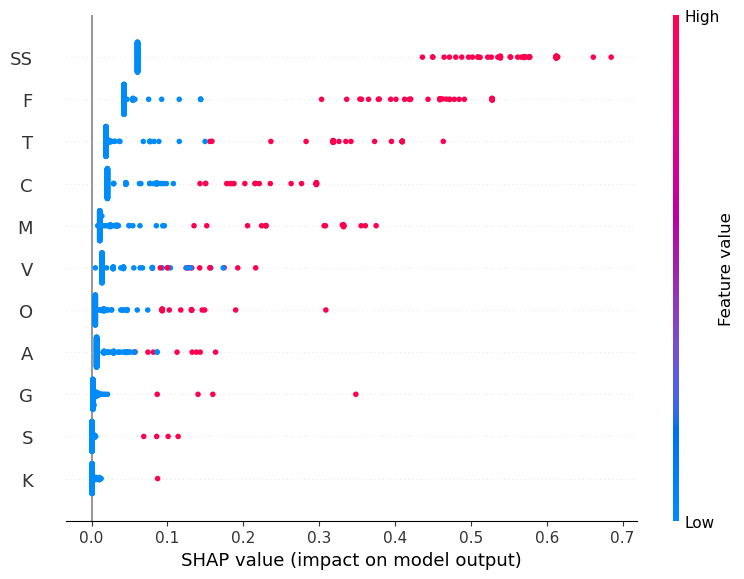


[SHAP] FAMILY — top features by average absolute contribution
 1. SS  —  mean|SHAP|=0.1858
 2. F  —  mean|SHAP|=0.1131
 3. T  —  mean|SHAP|=0.0595
 4. C  —  mean|SHAP|=0.0525
 5. M  —  mean|SHAP|=0.0441
 6. V  —  mean|SHAP|=0.0289
 7. O  —  mean|SHAP|=0.0192
 8. A  —  mean|SHAP|=0.0158
 9. G  —  mean|SHAP|=0.0062
10. S  —  mean|SHAP|=0.0026

[SHAP] Random Forest — EVOLUTION (global)


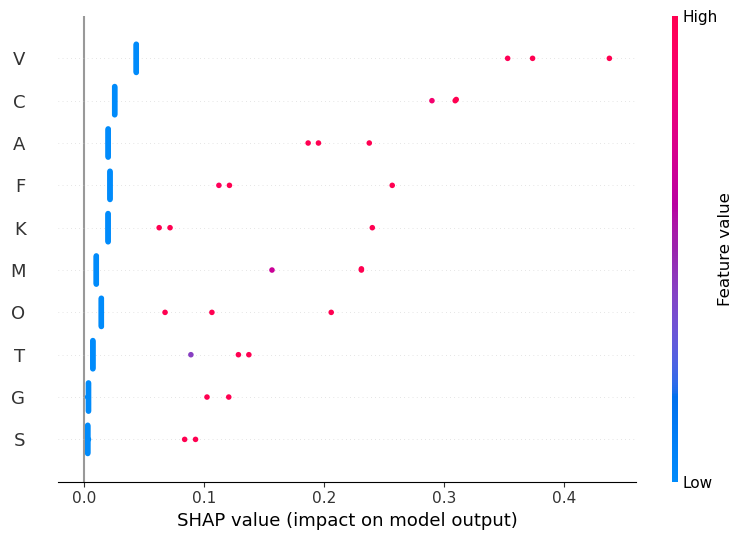


[SHAP] EVOLUTION — top features by average absolute contribution
 1. V  —  mean|SHAP|=0.0802
 2. C  —  mean|SHAP|=0.0550
 3. A  —  mean|SHAP|=0.0398
 4. F  —  mean|SHAP|=0.0365
 5. K  —  mean|SHAP|=0.0310
 6. M  —  mean|SHAP|=0.0309
 7. O  —  mean|SHAP|=0.0262
 8. T  —  mean|SHAP|=0.0190
 9. G  —  mean|SHAP|=0.0111
10. S  —  mean|SHAP|=0.0089


In [43]:
# =========================================================
# SHAP interpretability

shap.initjs()

# -----------------------
# FAMILY
# -----------------------
explainer_fam = shap.TreeExplainer(rf_fam)
shap_values_fam = explainer_fam.shap_values(X_test_fam)

Xtf = X_test_fam.values
fn_fam = list(X_test_fam.columns)

#Convert shap_values into consistent 2D form (N samples × F features)
#If multi-class, aggregate absolute contributions across all classes
if isinstance(shap_values_fam, list):
    sv_fam = np.array(shap_values_fam)   # (C, N, F)
    sv_fam = np.transpose(sv_fam, (1, 2, 0))  # (N, F, C)
elif isinstance(shap_values_fam, np.ndarray) and shap_values_fam.ndim == 3:
    sv_fam = shap_values_fam             # (N, F, C)
else:
    sv_fam = np.array(shap_values_fam)   # (N, F)

# Collapse to 2D by summing absolute contributions across classes
if sv_fam.ndim == 3:
    sv2d_fam = np.sum(np.abs(sv_fam), axis=2)  # (N, F)
else:
    sv2d_fam = sv_fam

#plots shap plot of family
print("\n[SHAP] Random Forest — FAMILY")
shap.summary_plot(sv2d_fam, Xtf, feature_names=fn_fam, show=True)

# quick text summary of the top contributors (mean |SHAP| per feature)
fam_importance = np.abs(sv2d_fam).mean(axis=0)
fam_top_idx = np.argsort(fam_importance)[::-1]
print("\n[SHAP] FAMILY — top features by average absolute contribution")
for rank in range(min(10, len(fn_fam))):
    j = fam_top_idx[rank]
    print(f"{rank+1:>2}. {fn_fam[j]}  —  mean|SHAP|={fam_importance[j]:.4f}")

# --------------------------
# EVOLUTION
# --------------------------
explainer_evo = shap.TreeExplainer(rf_evo)
shap_values_evo = explainer_evo.shap_values(X_test_evo)

# full names (used inside the model)
evo_feature_names = [f"log1p_{c}_z" for c in rate_cols]
Xte = np.asarray(X_test_evo)

# pretty names for display only
evo_feature_pretty = rate_cols  # ["A","G","O","T","V","C","F","K","M","S"]

# Convert SHAP values into 2D array
if isinstance(shap_values_evo, list):
    sv_evo = np.array(shap_values_evo)           # (C, N, F)
    sv_evo = np.transpose(sv_evo, (1, 2, 0))     # (N, F, C)
elif isinstance(shap_values_evo, np.ndarray) and shap_values_evo.ndim == 3:
    sv_evo = shap_values_evo                     # (N, F, C)
else:
    sv_evo = np.array(shap_values_evo)           # (N, F)

# collapse to 2D for global plot
if sv_evo.ndim == 3:
    sv2d_evo = np.sum(np.abs(sv_evo), axis=2)    # (N, F)
else:
    sv2d_evo = sv_evo

#SHAP summary plot with clean labels
print("\n[SHAP] Random Forest — EVOLUTION (global)")
shap.summary_plot(sv2d_evo, Xte, feature_names=evo_feature_pretty, show=True)

# quick text summary with clean labels
evo_importance = np.abs(sv2d_evo).mean(axis=0)
evo_top_idx = np.argsort(evo_importance)[::-1]
print("\n[SHAP] EVOLUTION — top features by average absolute contribution")
for rank in range(min(10, len(evo_feature_pretty))):
    j = evo_top_idx[rank]
    print(f"{rank+1:>2}. {evo_feature_pretty[j]}  —  mean|SHAP|={evo_importance[j]:.4f}")
      # (N, F)


- For the family dataset, the single binary feature SS (sexual selection) dominates model predictions by a large margin, followed by traits like F (female choice) and T (territoriality). Most other traits have smaller and often negligible contributions. This suggests the model mostly keys off one or two strong binary indicators, which likely limits generalization.
- For the evolution dataset, importance is spread across several continuous rate features. V (visual traits) has the largest average impact, followed by C (competition), A (acoustic), and F (female choice). Unlike family, no single variable dominates completely — instead, multiple rates contribute modestly, making predictions more balanced.

Overall, the family model leans heavily on a few binary traits (especially SS), while the evolution model distributes influence across a wider set of rate-based features, indicating that continuous rates carry richer predictive signal even if the model’s raw accuracy remains modest. 

---

## Conclusion and Interpretations

**Family_df (binary presence/absence)**

Arthropoda makes up most of the data; most other phyla are small. Traits are very sparse. Only SS and F show up often. All models score low—trees and forests overfit, and logistic regression is also weak. SHAP shows SS drives most decisions, with F and a few others adding small effects. There isn’t enough signal to generalize due to sparsity and imbalanced classes.

**Evolution_df (rate-based traits)**
Phyla are roughly balanced, but the rate features are skewed and correlated. Logistic regression does best (~50% accuracy, highest macro-F1); trees and forests trail. SHAP spreads importance across V, C, A, and F—no single rate dominates. The signal is better than in the binary data, but still limited.

**Overall interpretation**

Binary presence/absence doesn’t separate groups well and pushes models to lean on SS. Rate-based features carry more usable signal and lead to more balanced decisions, but overall performance is still modest.

Important note for the project changes since the proposal:

Compared to the proposal, the project shifted from predicting at the class/family level to using superphyla to reduce sparsity. Evolutionary rates were log-transformed and standardized instead of binarized, and evaluation emphasized balanced accuracy and macro F1 rather than ROC-AUC. Lastly, SHAP, originally planned as a secondary tool, became central in confirming trait reliance patterns across datasets.

---